#Ildebrando Simeoni 0001051567
##Blind source separation
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


Best mse value obtained in this notebook:  **0.0003187149229806395**

#Importing utilities

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras as ks
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
from matplotlib import pyplot as plt

#Dataset
The Dataset for this task is composed of a mixture of images from two separated famous datasets, namely: mnist and fashion_mnist.

##Data loading

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

In [ ]:
print(f'Size of mnist images before padding: {np.shape(mnist_x_train)[1:3]}, and fashion_mnist:{np.shape(fashion_mnist_x_train)[1:3]}')

#Normalization and padding
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

print(f'Size of mnist images after padding: {np.shape(mnist_x_train)[1:3]}, and fashion_mnist:{np.shape(fashion_mnist_x_train)[1:3]}')

Size of mnist images before padding: (28, 28), and fashion_mnist:(28, 28)
Size of mnist images after padding: (32, 32), and fashion_mnist:(32, 32)


##Data splitting
Starting from 60.000 images for both datasets, it has been decided to use 10.000 of the training ones for validation porpouses.

In [ ]:
mnist_x_val = mnist_x_train[-10000:]
mnist_y_val = mnist_y_train[-10000:]
mnist_x_train = mnist_x_train[:-10000]
mnist_y_train = mnist_y_train[:-10000]

fashion_mnist_x_val = fashion_mnist_x_train[-10000:]
fashion_mnist_y_val = fashion_mnist_y_train[-10000:]
fashion_mnist_x_train = fashion_mnist_x_train[:-10000]
fashion_mnist_y_train = fashion_mnist_y_train[:-10000]

print(f'Number of images used for validation: {mnist_x_val.shape[0]}')

Number of images used for validation: 10000


##Data generator
Data generator is used as provided, in particular it has been extensively used for the generation of training samples using a batch of 2**8; this was possible thanks to the huge number of possible combinations of 50.000 training images for each dataset.


In particular an important improvement in the performance (i.e. mse score) of the model was strictly correlated to this number of training samples.


For val generator a smaller amount of samples was sufficient, in particular I had to create before training a 'fixed' validation set due to Resource Exhaustion errors in training if validation data was given as a generator to the fit method.

For the test set a number of 20.000 samples was generated each time as asked in the trace, in order to better evaluate the model

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

In [ ]:
batchsize = 64
inputShape = (32,32,1)

train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, 2**8) 
val_generator = datagenerator(mnist_x_val, fashion_mnist_x_val, 10000 )
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, 20000)

x_val, y_val = next(val_generator)

##Looking at data
An example of the data we will have to work with is here shown; in particular the first image represent the type of images the model will have as input while the second one the ground truth for the output of the model.

Both are gray scale images, but while the first ones have shape (32,32) the second ones (i.e. the ground truth) have a shape of (32,64), this will result in some adjustment to the last layers of the model in order to obtain a desired shaped output

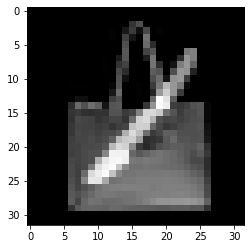

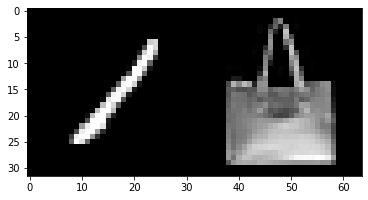

In [ ]:
plt.imshow(x_val[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_val[0], cmap='gray', interpolation='nearest')
plt.show()

#Model

As a first approach, being blind source separation a way more investigated problem in the audio field rather then the image one, I looked at possible architecture for the audio problem that could be suitable also for images.

In particular, a variety of unet (and unet variations) seemed suitable for this specific problem, see: 

*   https://paperswithcode.com/paper/wave-u-net-a-multi-scale-neural-network-for
*   https://cs.paperswithcode.com/paper/decoupling-magnitude-and-phase-estimation
* https://paperswithcode.com/paper/multi-task-u-net-for-music-source-separation

So a simple Unet, with some adjustment for the particular output needed, was firstly explored.

Tuning the Unet architecture however the best mse that I achieved was a 0.00065, knowing that there could be room for improvement I decided to swith to a simpler version of the Unet.

In particular, investigating a paper related to image segmentation of overlapping chromosomes (i.e.https://research.ijcaonline.org/volume95/number1/pxc3894861.pdf) a Unet-like model for 'mixture' of 'overlapping' images seemed a reasonable solution.

The aforementioned model is a simplified version of a Unet, namely an encoder-decoder architecture of convolutional, maxpooling and concatenation layers.

Starting from a model with only 400k parameters the performances increased up to 4M parameters, further increasements in model size didn't significantly improved the performance, they rather worsen them and made the model slower to train.

The parameters increasment of the model was mainly achieved by increasing the number of convolutional layers for each floor, which resulted in better performances.

The last layers of the model are structured in such a way to obtain two outputs (one for each of the mixed images, i.e. a mnist and a fashion_mnist one) and concatenate them into a single (32,64) output image.



In [ ]:
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, concatenate
from keras import callbacks

def create_model(input_shape=None, pooling=None):

    img_input = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1.2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1.3')(x)
    x_1a = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x_1a)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1.2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1.3')(x)
    x_2a = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x_2a)


    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1.2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1.3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x_2b = Conv2DTranspose(128, (2, 2), strides=(2, 2), input_shape=(None,23, 23, 1), name='block3_deconv1')(x)

    # Deconv Block 1
    x = concatenate([x_2a, x_2b])
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock1_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock1_conv2.2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock1_conv2.3')(x)
    x_1b = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), name='dblock1_deconv')(x)

    # Deconv Block 2
    x = concatenate([x_1a, x_1b], input_shape=(None,92, 92, None))
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv2.2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv2.3')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv2')(x)
    x = Conv2D(4, (1, 1), activation=None, padding='same', name='dblock2_conv3')(x)

    y1 = ks.layers.Conv2D(1, 1, activation='relu')(x)
    y2 = ks.layers.Conv2D(1, 1, activation='relu')(x)
    outputs = ks.layers.Concatenate(axis=2)([y1,y2])
    
    inputs = img_input
    # Create model
    model = Model(inputs, outputs, name='My_model')

    return model

My_model = create_model(input_shape=inputShape, pooling=None)
My_model.summary()

Model: "My_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   640         ['input_2[0][0]']                
                                                                                                  
 block1_conv1.2 (Conv2D)        (None, 32, 32, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_conv1.3 (Conv2D)        (None, 32, 32, 64)   36928       ['block1_conv1.2[0][0]']         
                                                                                           

A visual representation of the model is also here shown

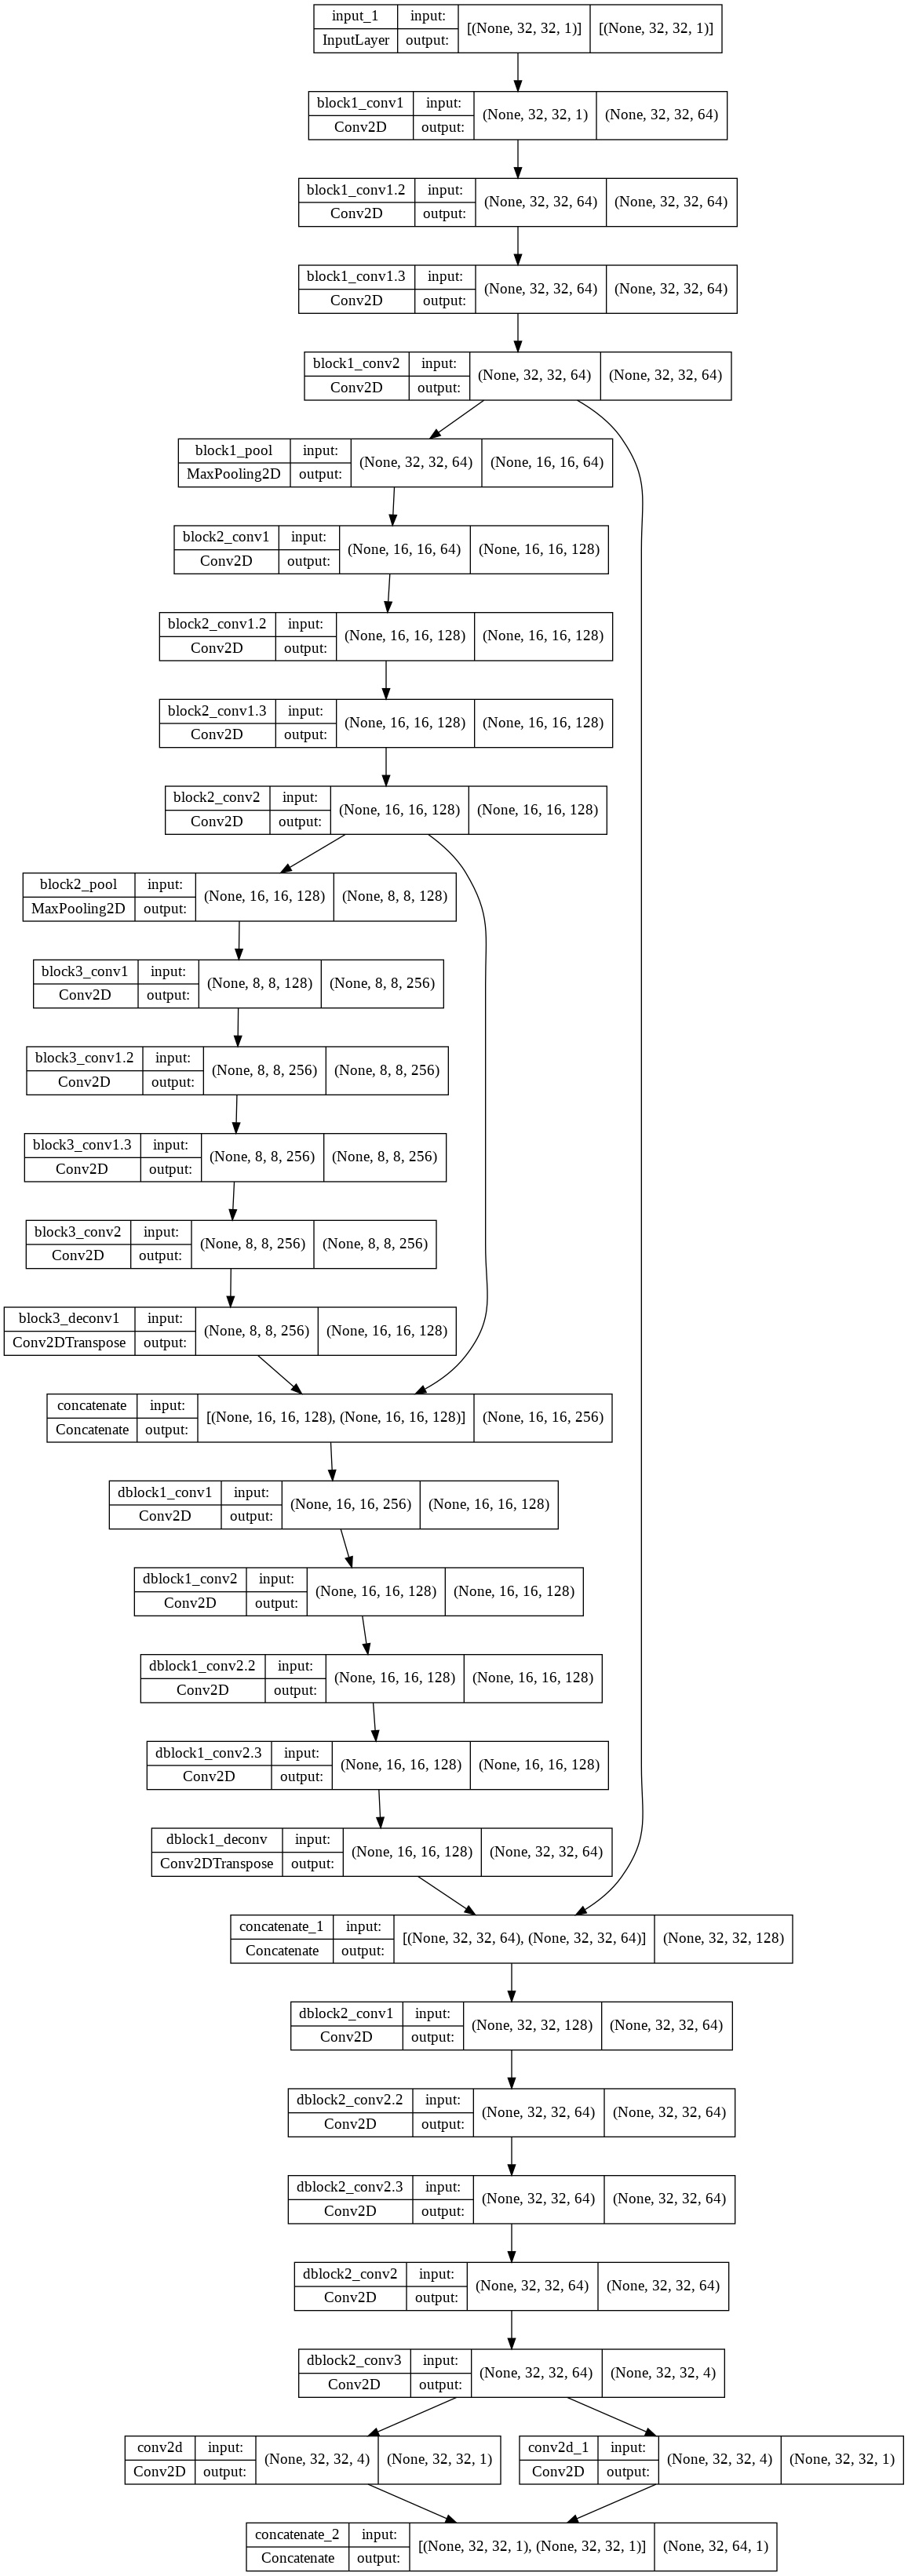

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model=My_model, to_file='model.png', show_shapes=True)

##Training


The following settings of parameters and callbacks is what enabled me to reach the best mse score, as loss function the mse has been choosen and Adam as optimizer.

Regarding the callback, thanks to the ReduceLROnPlateau callback, the learing rate dynamic adjustment enabled the loss function to decrease also after 40 epochs.

On the other end the EarlyStopping enable me to try different values for the number of epochs until no more improvement was detected.

In [ ]:
My_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='mse',metrics=['accuracy'])

**N.B. IMPORTANT**

Due to standard Colab GPU resource limitations a smarter approach to train the model was developed.

In particular, considering the huge number of training data (thanks to the use of the generators), a vast number of epochs was considered necessary to gradually decrease the mse value; this approach with a smaller number of steps per epoch was chosen over one with lower number of epochs and higher number of steps per epoch.

The model was trained over 300 epochs, 50 epochs at a time in smaller "sub-trainings" **computed in different notebooks** by saving weights of the model after each training and loading them before a new one, by doing that I ensured to train longer the model without running in Colab GPU limits, and also having the possibility to experiment with larger learing rates at advanced states of the training.

So if a rerun of the notebook is needed, load and save of weights before and after each "sub-training" is also needed.

Below are presented the outputs of each of the "sub-training" with a visual representation of the loss trend during training; as can be seen until epoch 300 there are no clear signs of overfitting, remembering that the mse values of the last epochs are orders of magnitude smaller than the first one, so any visual change of the loss should be appropriately considered with respect to the actual values of the loss function.


###Epochs 1-50

In [ ]:
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.00001, patience = 10, restore_best_weights = True)

callbacks = [reduce_on_plateau_callback, early_stopping_callback] 

history = My_model.fit(
    train_generator,
    epochs=50,
    batch_size = batchsize,
    steps_per_epoch=400,
    validation_steps=50,
    callbacks=callbacks,
    validation_data=(x_val,y_val)) 

Epoch 1/50
400/400 [==============================] - 111s 238ms/step - loss: 0.0140 - accuracy: 0.7385 - val_loss: 0.0027 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - 95s 236ms/step - loss: 0.0020 - accuracy: 0.7417 - val_loss: 0.0017 - val_accuracy: 0.7418 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - 95s 237ms/step - loss: 0.0014 - accuracy: 0.7415 - val_loss: 0.0014 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - 95s 237ms/step - loss: 0.0012 - accuracy: 0.7415 - val_loss: 0.0011 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 5/50
400/400 [==============================] - 95s 237ms/step - loss: 0.0010 - accuracy: 0.7417 - val_loss: 0.0011 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 6/50
400/400 [==============================] - 95s 237ms/step - loss: 9.5414e-04 - accuracy: 0.7419 - val_loss: 8.9144e-04 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 7/50
400/400 [=======================

A visual representation of the training was here shown in order to spot any possible sign of overfitting.

In [ ]:
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()


As can be observed looking at the graph, the loss function smoothly decrease until it reaches its lowest value at around the last few epochs of the training, so no overfitting is detected

In [ ]:
display_history(history)

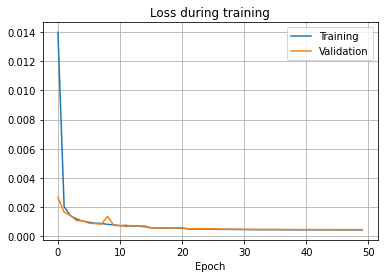

###Epochs 50-100

In [ ]:
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.000001, patience = 10, restore_best_weights = True)

callbacks = [reduce_on_plateau_callback, early_stopping_callback] 

history = My_model.fit(
    train_generator,
    epochs=50,
    batch_size = batchsize,
    steps_per_epoch=400,
    validation_steps=50,
    callbacks=callbacks,
    validation_data=(x_val,y_val)) 

Epoch 1/50
400/400 [==============================] - 108s 233ms/step - loss: 7.3866e-04 - accuracy: 0.7419 - val_loss: 4.9276e-04 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - 92s 230ms/step - loss: 5.1203e-04 - accuracy: 0.7418 - val_loss: 5.4002e-04 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - 92s 229ms/step - loss: 5.4938e-04 - accuracy: 0.7419 - val_loss: 5.1954e-04 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - 92s 230ms/step - loss: 5.6401e-04 - accuracy: 0.7420 - val_loss: 6.7046e-04 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 5/50
400/400 [==============================] - 92s 230ms/step - loss: 5.4191e-04 - accuracy: 0.7417 - val_loss: 5.5696e-04 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 6/50
400/400 [==============================] - ETA: 0s - loss: 5.5916e-04 - accuracy: 0.7418
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00050000002374

In [ ]:
display_history(history)

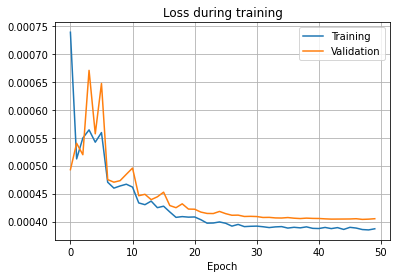

###Epochs 100-150

In [ ]:
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.000001, patience = 10, restore_best_weights = True)

callbacks = [reduce_on_plateau_callback, early_stopping_callback] 

history = My_model.fit(
    train_generator,
    epochs=50,
    batch_size = batchsize,
    steps_per_epoch=400,
    validation_steps=50,
    callbacks=callbacks,
    validation_data=(x_val,y_val)) 

Epoch 1/50
400/400 [==============================] - 111s 239ms/step - loss: 7.0373e-04 - accuracy: 0.7418 - val_loss: 4.3415e-04 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - 95s 238ms/step - loss: 4.4292e-04 - accuracy: 0.7418 - val_loss: 4.3024e-04 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 3/50
400/400 [==============================] - 95s 238ms/step - loss: 4.5210e-04 - accuracy: 0.7418 - val_loss: 5.0428e-04 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 4/50
400/400 [==============================] - 95s 238ms/step - loss: 4.5261e-04 - accuracy: 0.7416 - val_loss: 4.5050e-04 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 5/50
400/400 [==============================] - 95s 238ms/step - loss: 4.6422e-04 - accuracy: 0.7419 - val_loss: 4.4054e-04 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 6/50
400/400 [==============================] - ETA: 0s - loss: 4.7101e-04 - accuracy: 0.7420
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00050000002374

In [ ]:
display_history(history)

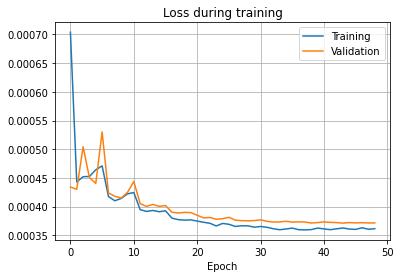

###Epochs 150-200

In [ ]:
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.000001, patience = 10, restore_best_weights = True)

callbacks = [reduce_on_plateau_callback, early_stopping_callback] 

history = My_model.fit(
    train_generator,
    epochs=50,
    batch_size = batchsize,
    steps_per_epoch=400,
    validation_steps=50,
    callbacks=callbacks,
    validation_data=(x_val,y_val)) 

Epoch 1/50
400/400 [==============================] - 48s 114ms/step - loss: 6.2052e-04 - accuracy: 0.7419 - val_loss: 4.1957e-04 - val_accuracy: 0.7407
Epoch 2/50
400/400 [==============================] - 45s 112ms/step - loss: 4.4185e-04 - accuracy: 0.7422 - val_loss: 4.6893e-04 - val_accuracy: 0.7407
Epoch 3/50
400/400 [==============================] - 45s 112ms/step - loss: 4.4378e-04 - accuracy: 0.7418 - val_loss: 4.4007e-04 - val_accuracy: 0.7407
Epoch 4/50
400/400 [==============================] - 45s 112ms/step - loss: 4.6658e-04 - accuracy: 0.7422 - val_loss: 4.7571e-04 - val_accuracy: 0.7407
Epoch 5/50
400/400 [==============================] - 45s 112ms/step - loss: 5.0367e-04 - accuracy: 0.7415 - val_loss: 5.3473e-04 - val_accuracy: 0.7407
Epoch 6/50
400/400 [==============================] - 45s 112ms/step - loss: 4.6197e-04 - accuracy: 0.7416 - val_loss: 5.0803e-04 - val_accuracy: 0.7407

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
E

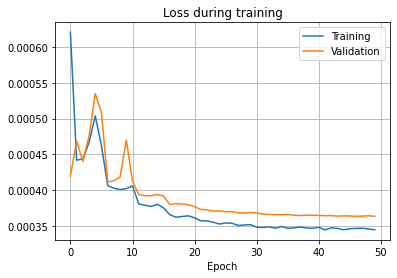

In [ ]:
display_history(history)

###Epochs 200-250

In [ ]:
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.000001, patience = 10, restore_best_weights = True)

callbacks = [reduce_on_plateau_callback, early_stopping_callback] 

history = My_model.fit(
    train_generator,
    epochs=50,
    batch_size = batchsize,
    steps_per_epoch=400,
    validation_steps=50,
    callbacks=callbacks,
    validation_data=(x_val,y_val)) 

Epoch 1/50
400/400 [==============================] - 49s 115ms/step - loss: 8.6076e-04 - accuracy: 0.7420 - val_loss: 4.4376e-04 - val_accuracy: 0.7415
Epoch 2/50
400/400 [==============================] - 45s 113ms/step - loss: 4.1973e-04 - accuracy: 0.7421 - val_loss: 4.2100e-04 - val_accuracy: 0.7415
Epoch 3/50
400/400 [==============================] - 45s 113ms/step - loss: 4.0458e-04 - accuracy: 0.7416 - val_loss: 4.1024e-04 - val_accuracy: 0.7415
Epoch 4/50
400/400 [==============================] - 45s 113ms/step - loss: 4.0157e-04 - accuracy: 0.7419 - val_loss: 4.0451e-04 - val_accuracy: 0.7415
Epoch 5/50
400/400 [==============================] - 45s 113ms/step - loss: 4.0281e-04 - accuracy: 0.7420 - val_loss: 4.2682e-04 - val_accuracy: 0.7415
Epoch 6/50
400/400 [==============================] - 45s 113ms/step - loss: 4.0289e-04 - accuracy: 0.7422 - val_loss: 4.0923e-04 - val_accuracy: 0.7415

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
E

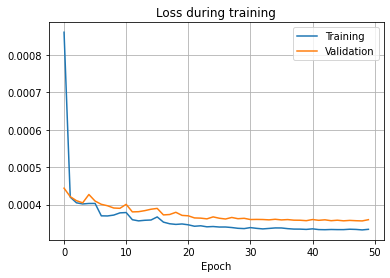

In [ ]:
display_history(history)

###Epochs 250-300

In [ ]:
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.000001, patience = 10, restore_best_weights = True)

callbacks = [reduce_on_plateau_callback, early_stopping_callback] 

history = My_model.fit(
    train_generator,
    epochs=50,
    batch_size = batchsize,
    steps_per_epoch=400,
    validation_steps=50,
    callbacks=callbacks,
    validation_data=(x_val,y_val)) 

Epoch 1/50
400/400 [==============================] - 46s 115ms/step - loss: 6.2142e-04 - accuracy: 0.7421 - val_loss: 3.8455e-04 - val_accuracy: 0.7407
Epoch 2/50
400/400 [==============================] - 45s 113ms/step - loss: 3.8327e-04 - accuracy: 0.7417 - val_loss: 3.7182e-04 - val_accuracy: 0.7407
Epoch 3/50
400/400 [==============================] - 45s 113ms/step - loss: 3.8533e-04 - accuracy: 0.7418 - val_loss: 3.8026e-04 - val_accuracy: 0.7407
Epoch 4/50
400/400 [==============================] - 45s 112ms/step - loss: 3.9742e-04 - accuracy: 0.7419 - val_loss: 3.8193e-04 - val_accuracy: 0.7407
Epoch 5/50
400/400 [==============================] - 45s 114ms/step - loss: 3.9784e-04 - accuracy: 0.7421 - val_loss: 3.9116e-04 - val_accuracy: 0.7407
Epoch 6/50
400/400 [==============================] - 45s 113ms/step - loss: 4.1132e-04 - accuracy: 0.7420 - val_loss: 4.0345e-04 - val_accuracy: 0.7407

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
E

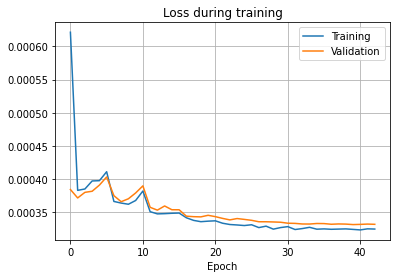

In [ ]:
display_history(history)

##Evaluation
As stated in the trace, the metric we needed to use to evaluate the results is the mean squared error between predicted and ground truth images.

In particular the mse is computed over 20000 samples randomly generated from the two test_sets for a total number of 10 times.

After that the best score obtained, the mean and the standard deviation over the 10 tests are presented.

The best mse value obtained is:  **0.0003187149229806395**

The standard deviation obtained over 10 iterations is: 2.009212056503213e-06, which is indeed very small.

In [ ]:
mse = []
for i in range(0,10):
  x_test, y_test = next (test_generator)
  predictions = My_model.predict(x_test)
  predictions = predictions.reshape((20000,32,64))
  mse.append(np.mean(np.square(y_test-predictions)))

print(f'The mean mse score obtained over 10 iterations is: {np.mean(mse)}')
print(f'The best mse score obtained over 10 iterations is: {np.min(mse)}')
print(f'The standard deviation obtained over 10 iterations is: {np.std(mse)}')

The mean mse score obtained over 10 iterations is: 0.00032351734564012145
The best mse score obtained over 10 iterations is: 0.0003187149229806395
The standard deviation obtained over 10 iterations is: 2.009212056503213e-06


##Visual example of model prediction
In this last cell it's presented a visual prediction of the model which, as can be observed, obtained an optimal result with respect to the ground truth

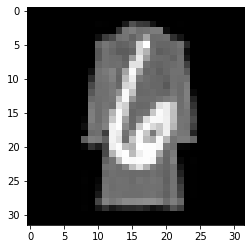

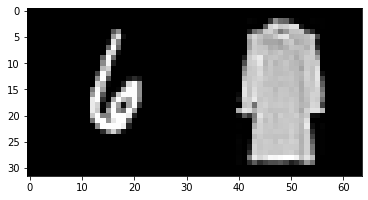

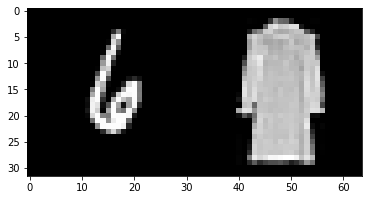

In [ ]:
example_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,4)
x_example, y_example = next(example_generator)

plt.imshow(x_example[2],cmap='gray', interpolation='nearest');
plt.show()
plt.imshow(y_example[2],cmap='gray', interpolation='nearest');
plt.show()

predictions = My_model.predict(x_example[2:3])

plt.imshow(np.squeeze(predictions),cmap='gray', interpolation='nearest');
plt.show()

In [ ]:
My_model.save_weights('Ildebrando_Simeoni.h5')